## Prepare Notebook

In [15]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Data Generating Process

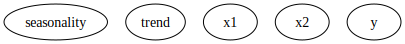

In [18]:
g = gr.Digraph()
g.node(name="seasonality", label="seasonality")
g.node(name="trend", label="trend")
g.node(name="x1", label="x1")
g.node(name="x2", label="x2")
g.node(name="y", label="y")
g  # noqa: B018

In [3]:
# date range
min_date = pd.to_datetime("2021-10-04")
max_date = pd.to_datetime("2024-03-25")

data_df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

n = data_df.shape[0]

data_df["dayofyear"] = data_df["date_week"].dt.dayofyear
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 3) - 1
data_df["cs"] = -np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["seasonality"] = 0.3 * (data_df["cs"] + data_df["cc"])
data_df["z"] = 0.3 * rng.gamma(shape=1, scale=2 / 3, size=n)

Text(0.5, 0.98, 'Data Components')

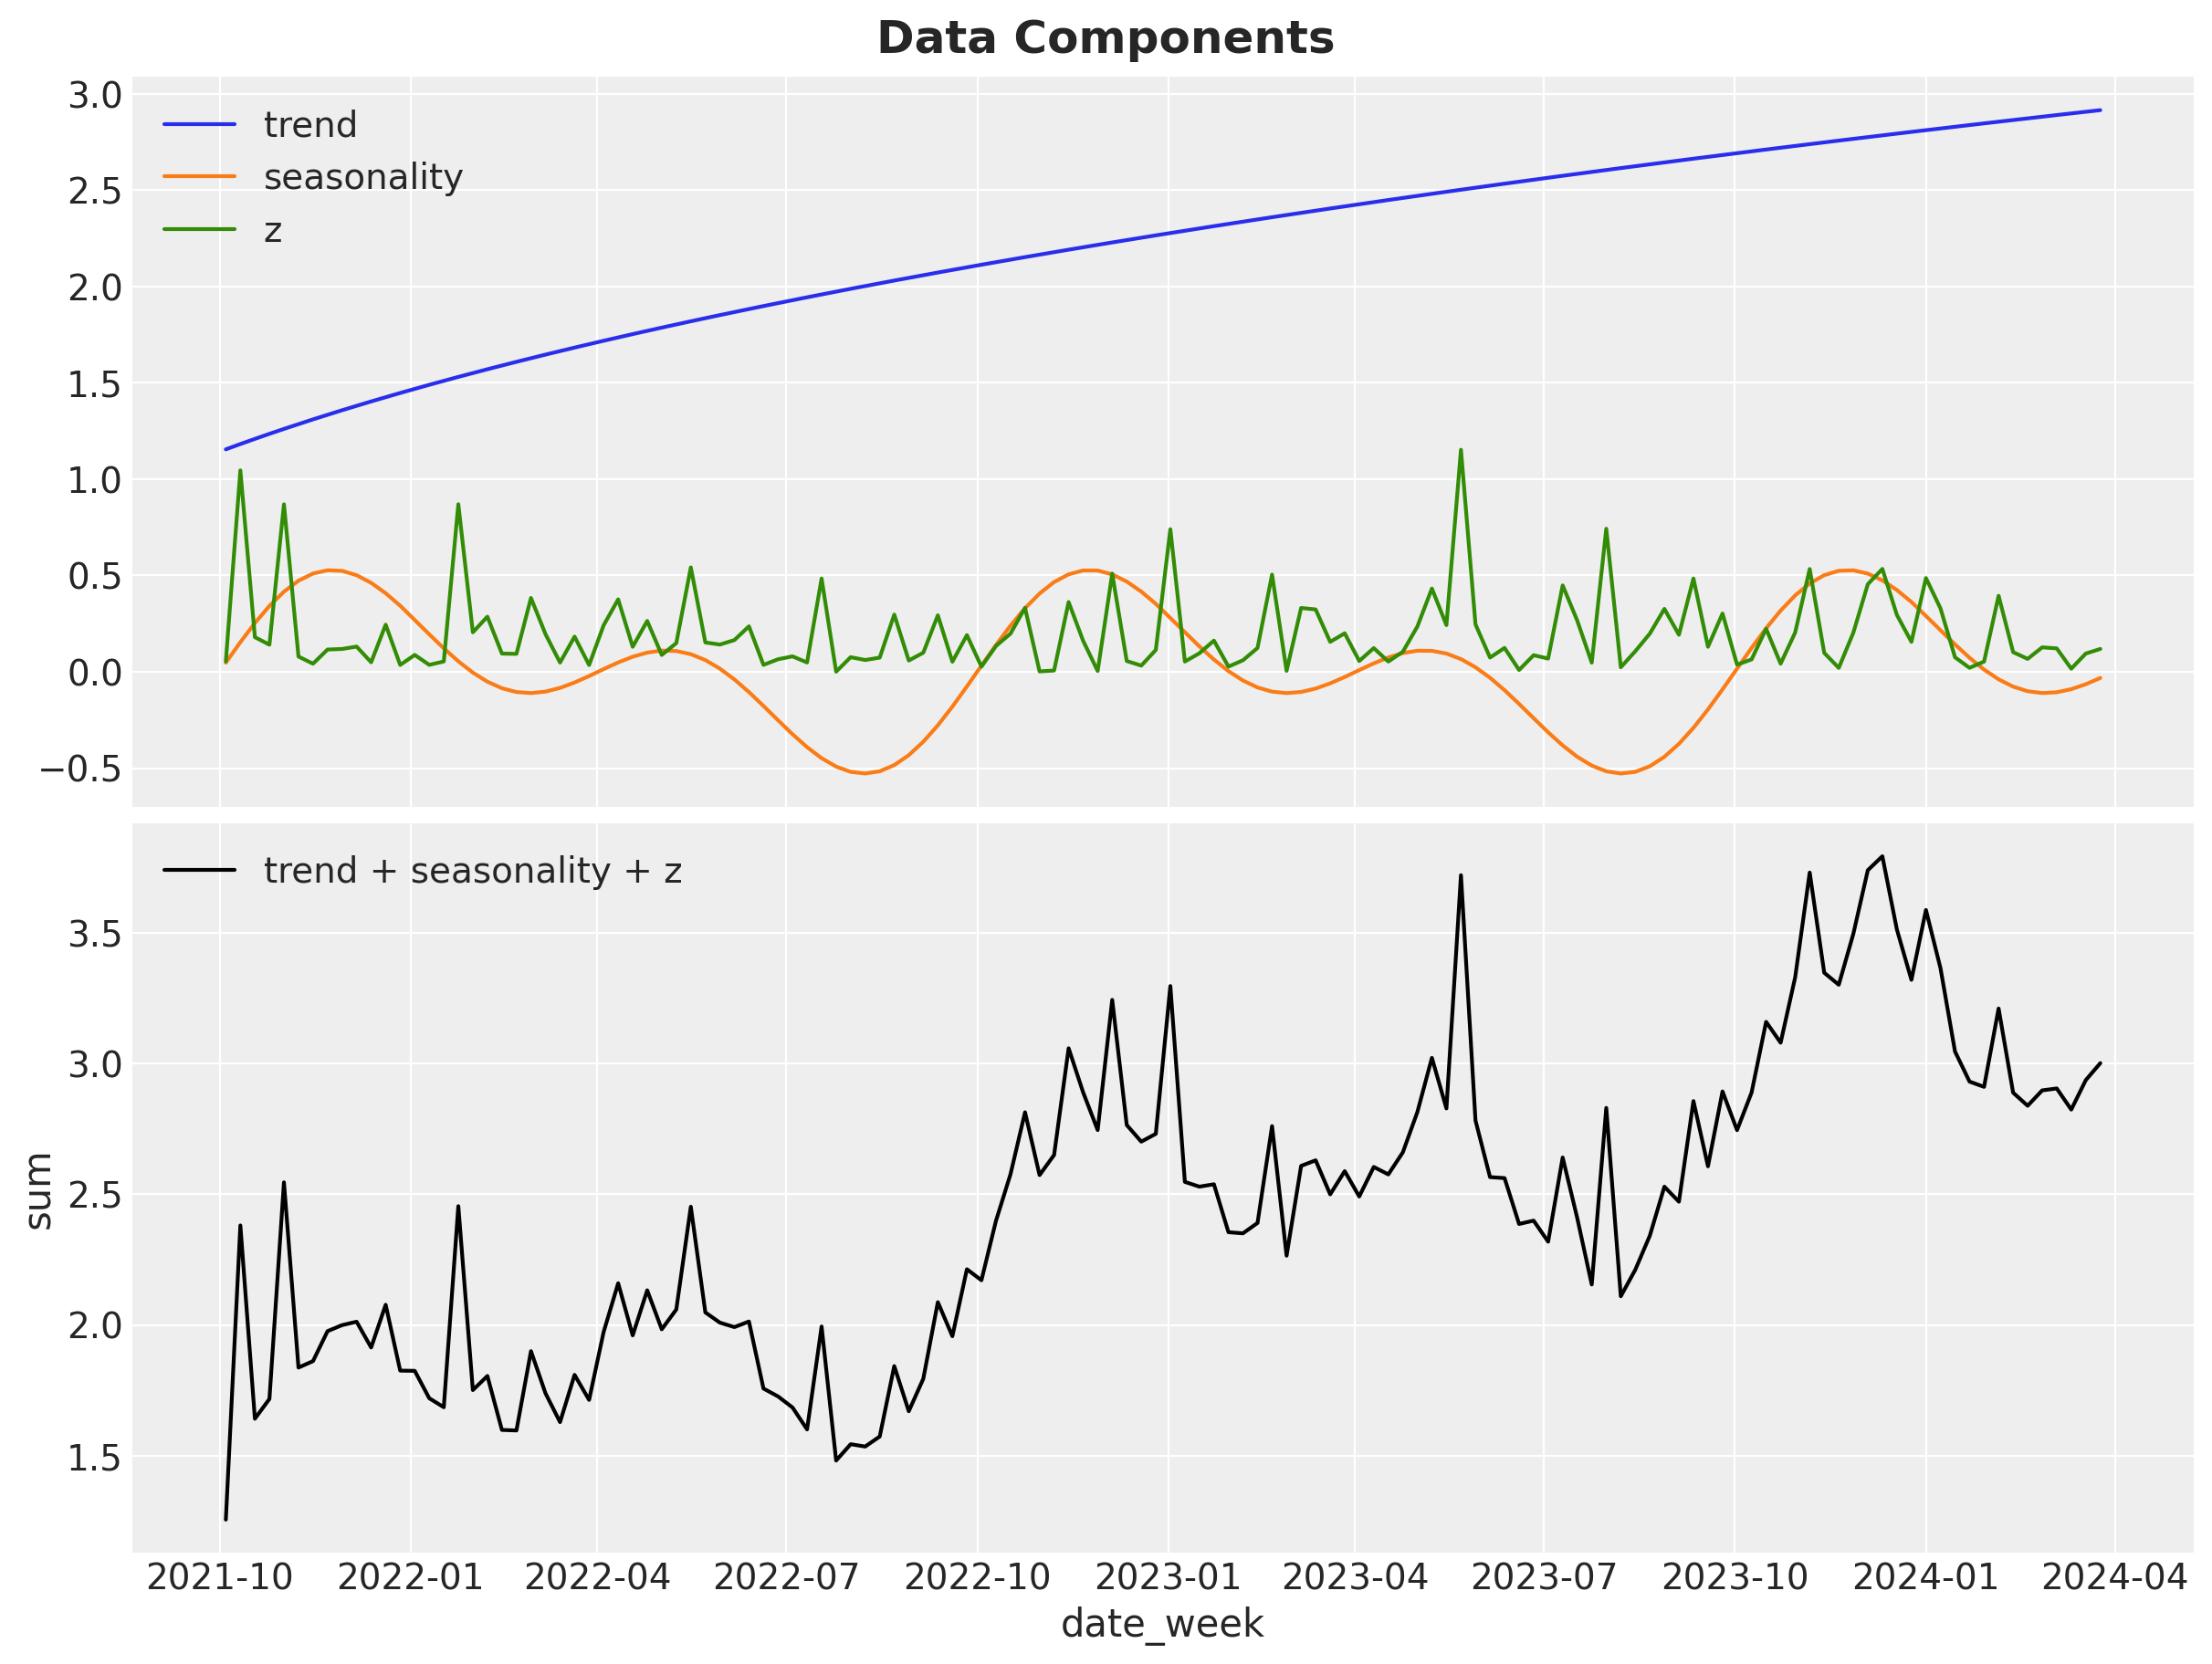

In [4]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="trend",
    color="C0",
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="seasonality",
    color="C1",
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date_week", y="z", color="C2", label="z", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z"),
    x="date_week",
    y="sum",
    color="black",
    label="trend + seasonality + z",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

In [5]:
data_df["x1"] = 1.2 * (
    0.5
    + 0.4 * data_df["seasonality"]
    + 0.6 * data_df["z"]
    + 0.1 * rng.poisson(lam=1, size=n)
)

data_df["x2"] = 0.3 * rng.gamma(shape=1, scale=1, size=n)

data_df["epsilon"] = rng.normal(loc=0, scale=0.1, size=n)

Text(0.5, 0.98, 'Data Components')

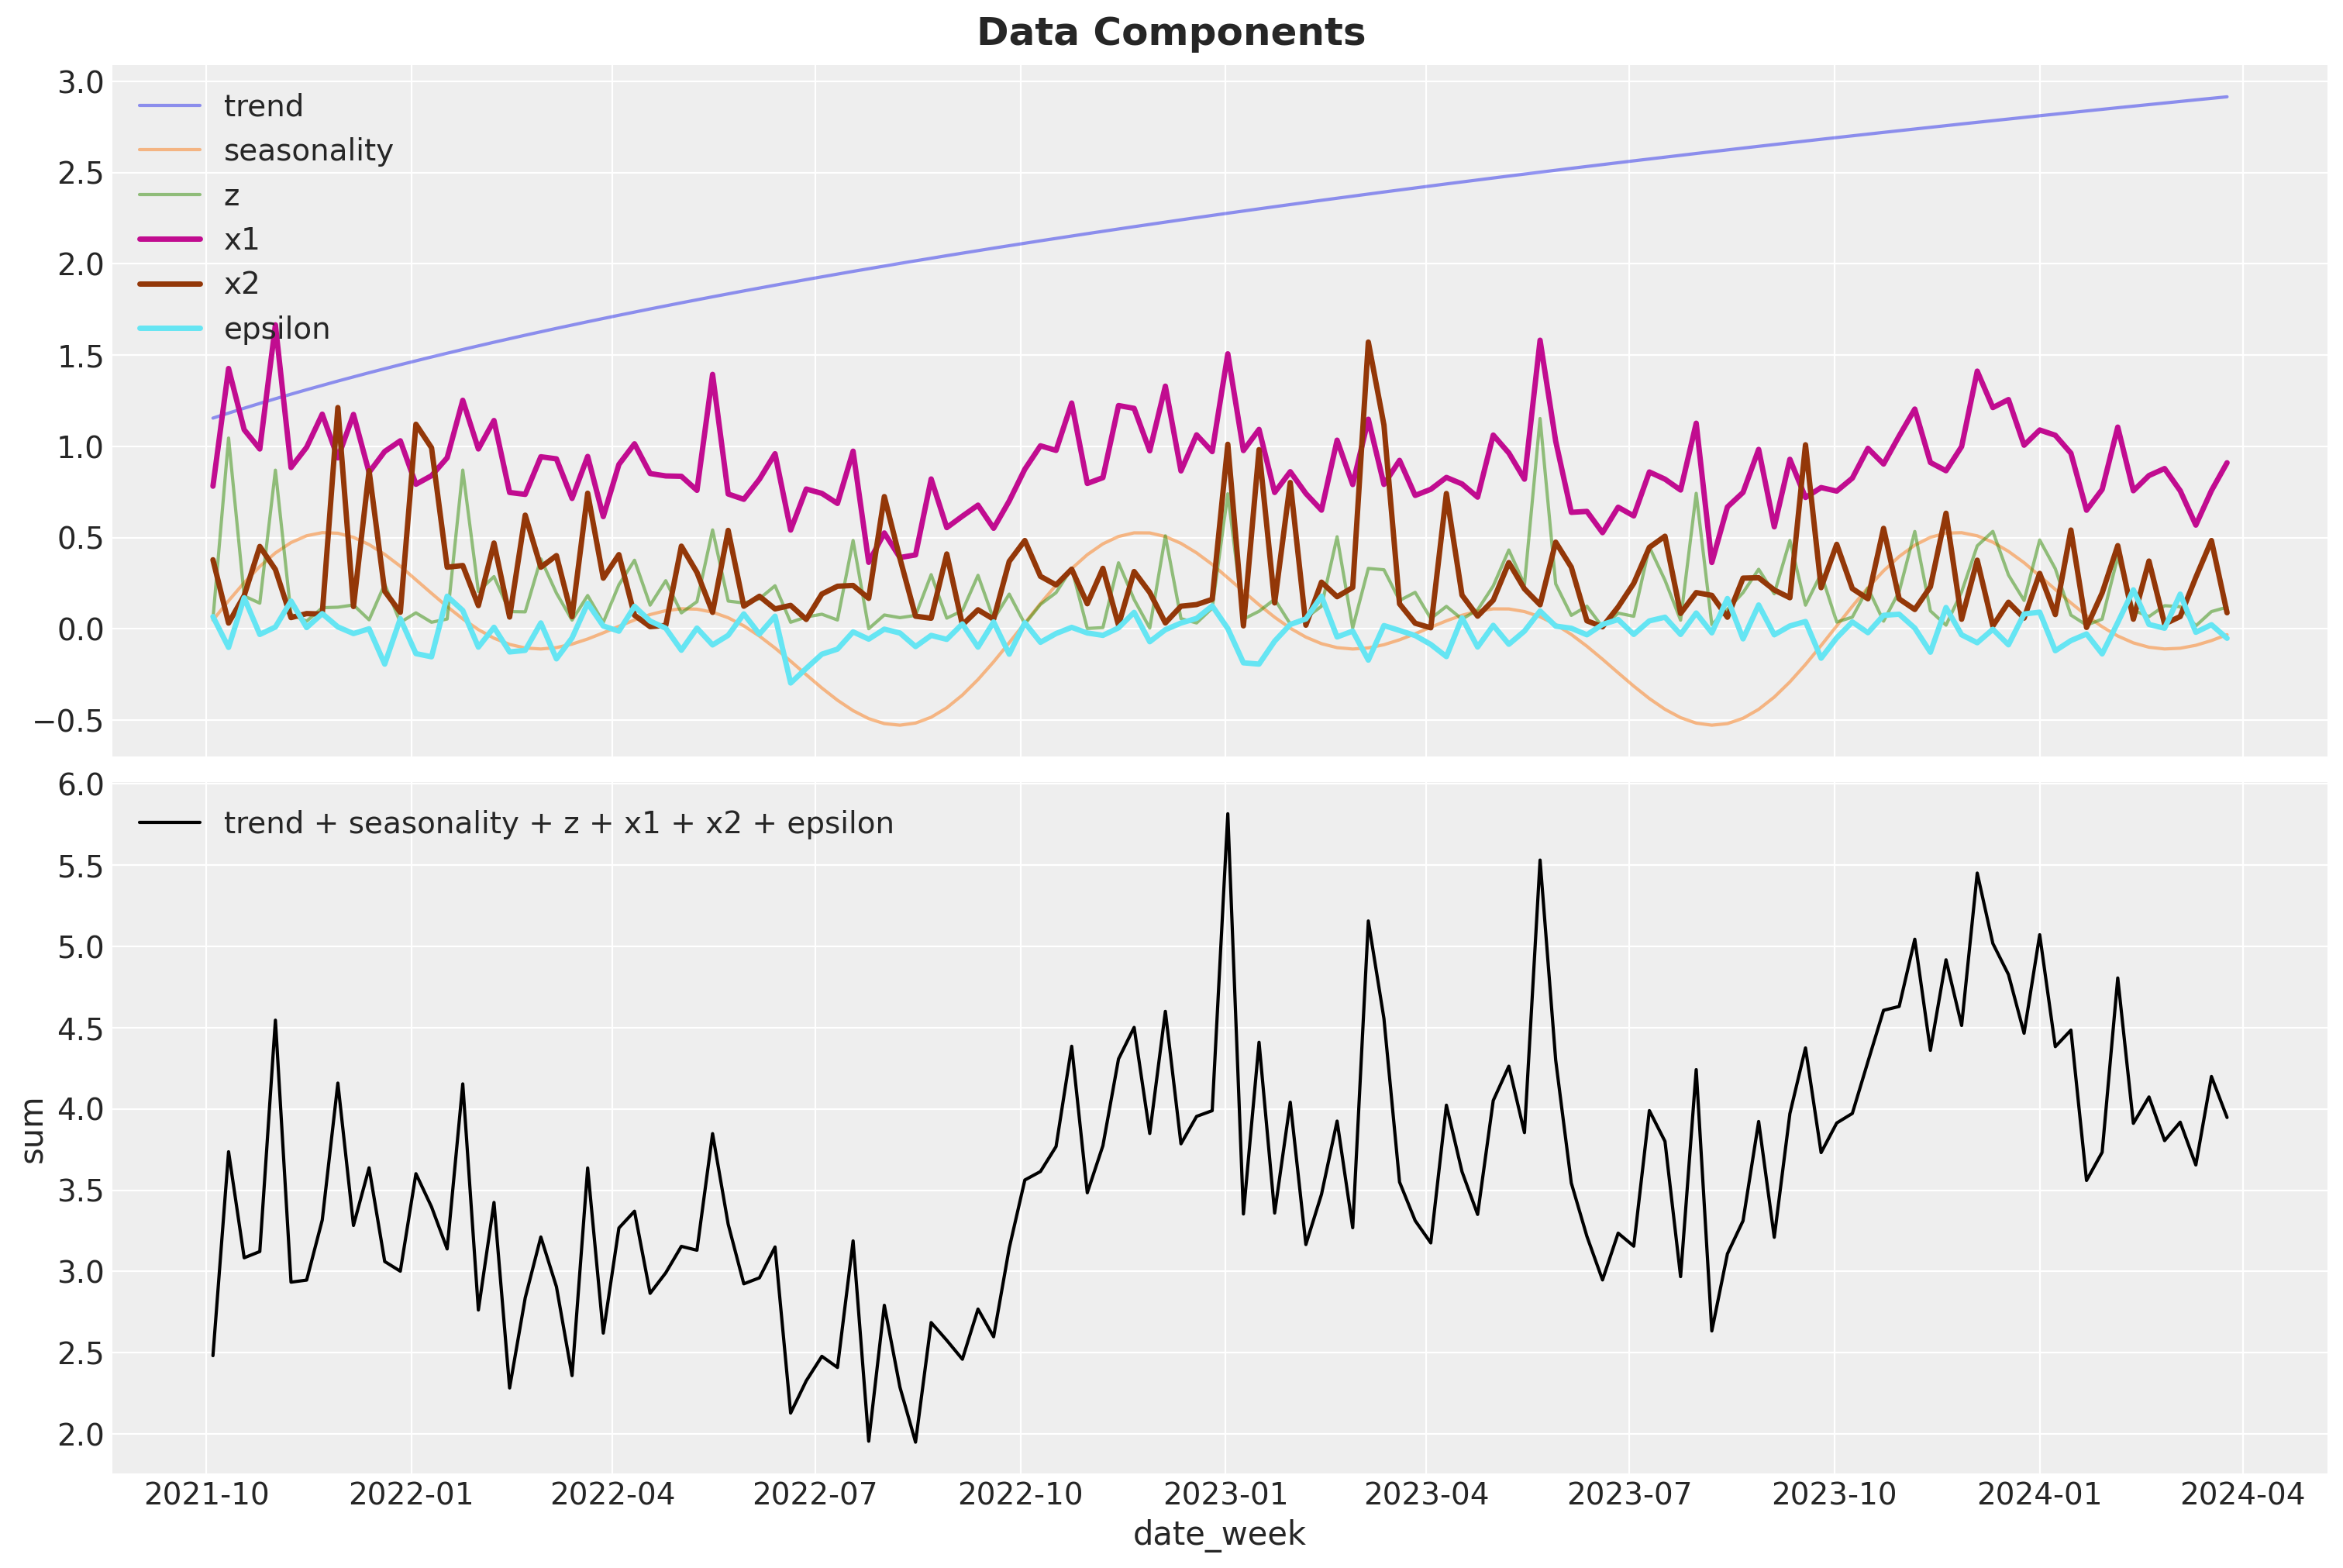

In [6]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(
    data=data_df, x="date_week", y="z", color="C2", alpha=0.5, label="z", ax=ax[0]
)
sns.lineplot(
    data=data_df, x="date_week", y="x1", color="C3", linewidth=2.5, label="x1", ax=ax[0]
)
sns.lineplot(
    data=data_df, x="date_week", y="x2", color="C4", linewidth=2.5, label="x2", ax=ax[0]
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z + x1 + x2 + epsilon"),
    x="date_week",
    y="sum",
    color="black",
    label="trend + seasonality + z + x1 + x2 + epsilon",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

In [7]:
def geometric_adstock(x, alpha: float = 0.0, l_max: int = 8):
    """Geometric adstock transformation."""
    cycles = [pt.concatenate([pt.zeros(i), x[: x.shape[0] - i]]) for i in range(l_max)]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    return pt.dot(w / pt.sum(w), x_cycle)


def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

In [8]:
# apply geometric adstock transformation
alpha1: float = 0.3
alpha2: float = 0.5

data_df["x1_adstock"] = (
    geometric_adstock(x=data_df["x1"].to_numpy(), alpha=alpha1, l_max=8)
    .eval()
    .flatten()
)

data_df["x2_adstock"] = (
    geometric_adstock(x=data_df["x2"].to_numpy(), alpha=alpha2, l_max=8)
    .eval()
    .flatten()
)

Text(0.5, 0.98, 'Adstock Transformation')

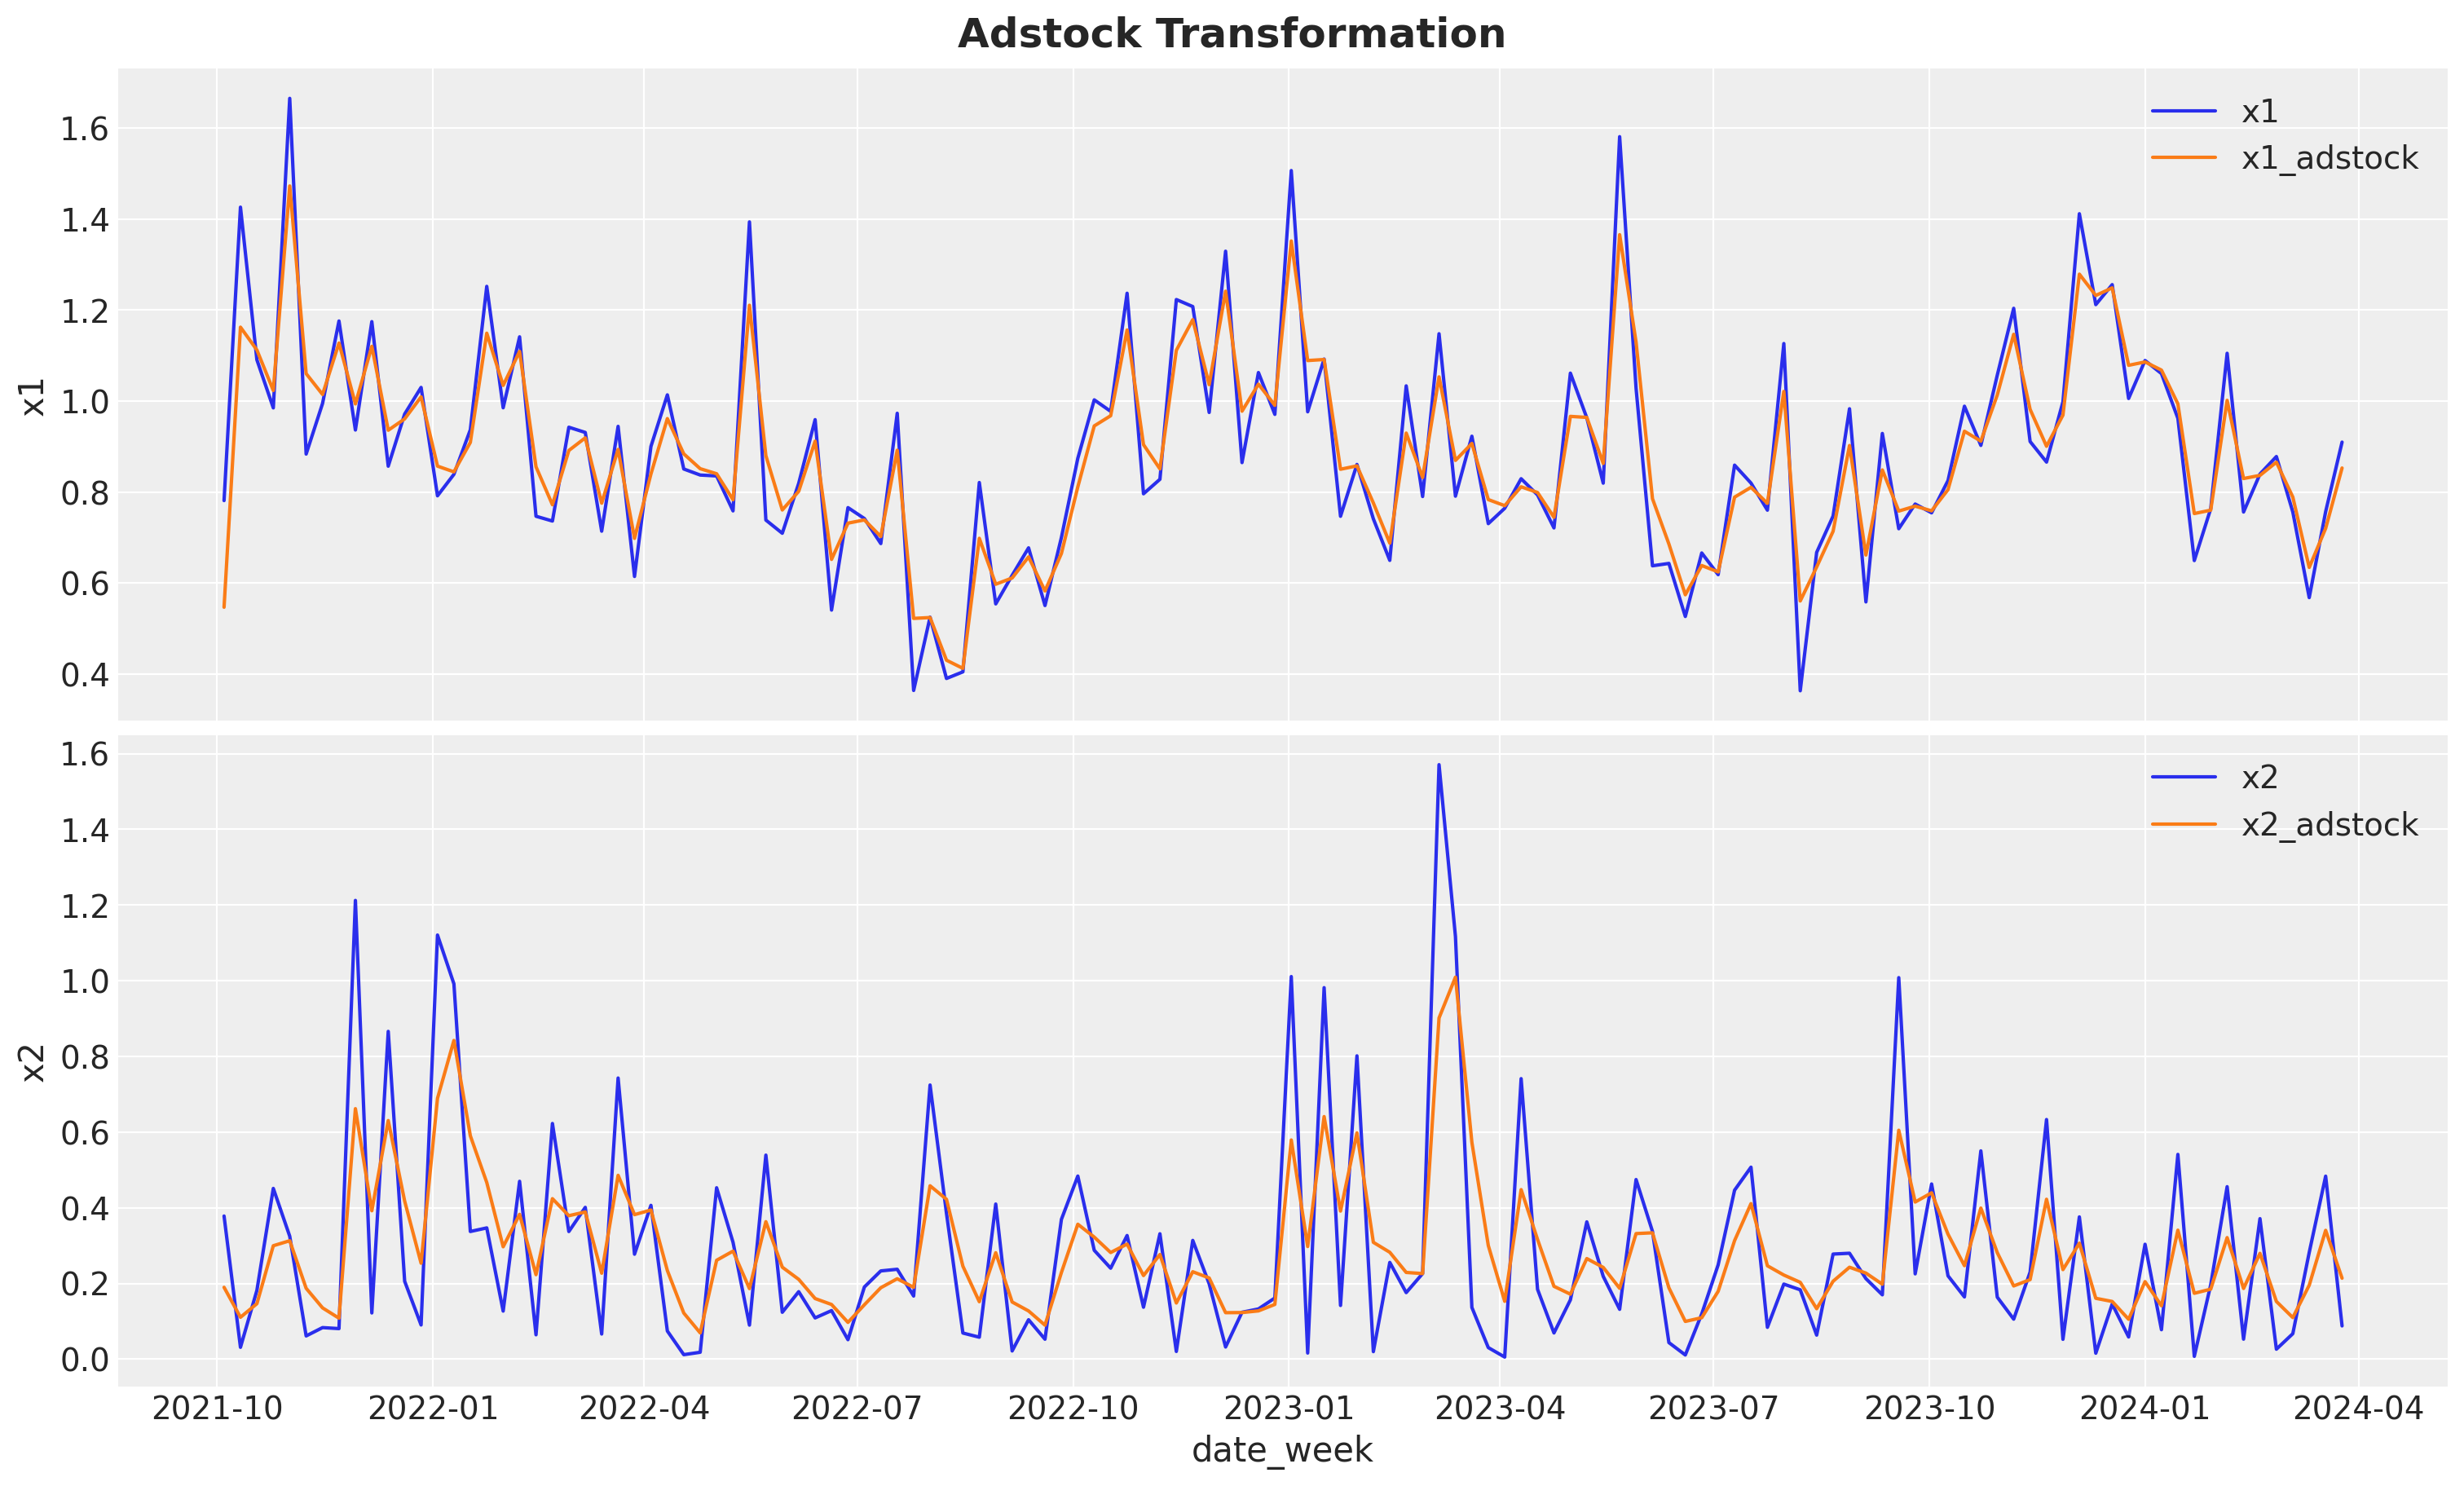

In [9]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(15, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=data_df, color="C0", label="x1", ax=ax[0])
sns.lineplot(
    x="date_week",
    y="x1_adstock",
    data=data_df,
    color="C1",
    label="x1_adstock",
    ax=ax[0],
)
sns.lineplot(x="date_week", y="x2", data=data_df, color="C0", label="x2", ax=ax[1])
sns.lineplot(
    x="date_week",
    y="x2_adstock",
    data=data_df,
    color="C1",
    label="x2_adstock",
    ax=ax[1],
)

fig.suptitle("Adstock Transformation", fontsize=18, fontweight="bold")

In [10]:
# apply saturation transformation
lam1: float = 1.0
lam2: float = 2.5

data_df["x1_adstock_saturated"] = logistic_saturation(
    x=data_df["x1_adstock"].to_numpy(), lam=lam1
).eval()

data_df["x2_adstock_saturated"] = logistic_saturation(
    x=data_df["x2_adstock"].to_numpy(), lam=lam2
).eval()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_18011/4029364520.py:14: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


Text(0.5, 0.98, 'Media Costs Data - Transformed')

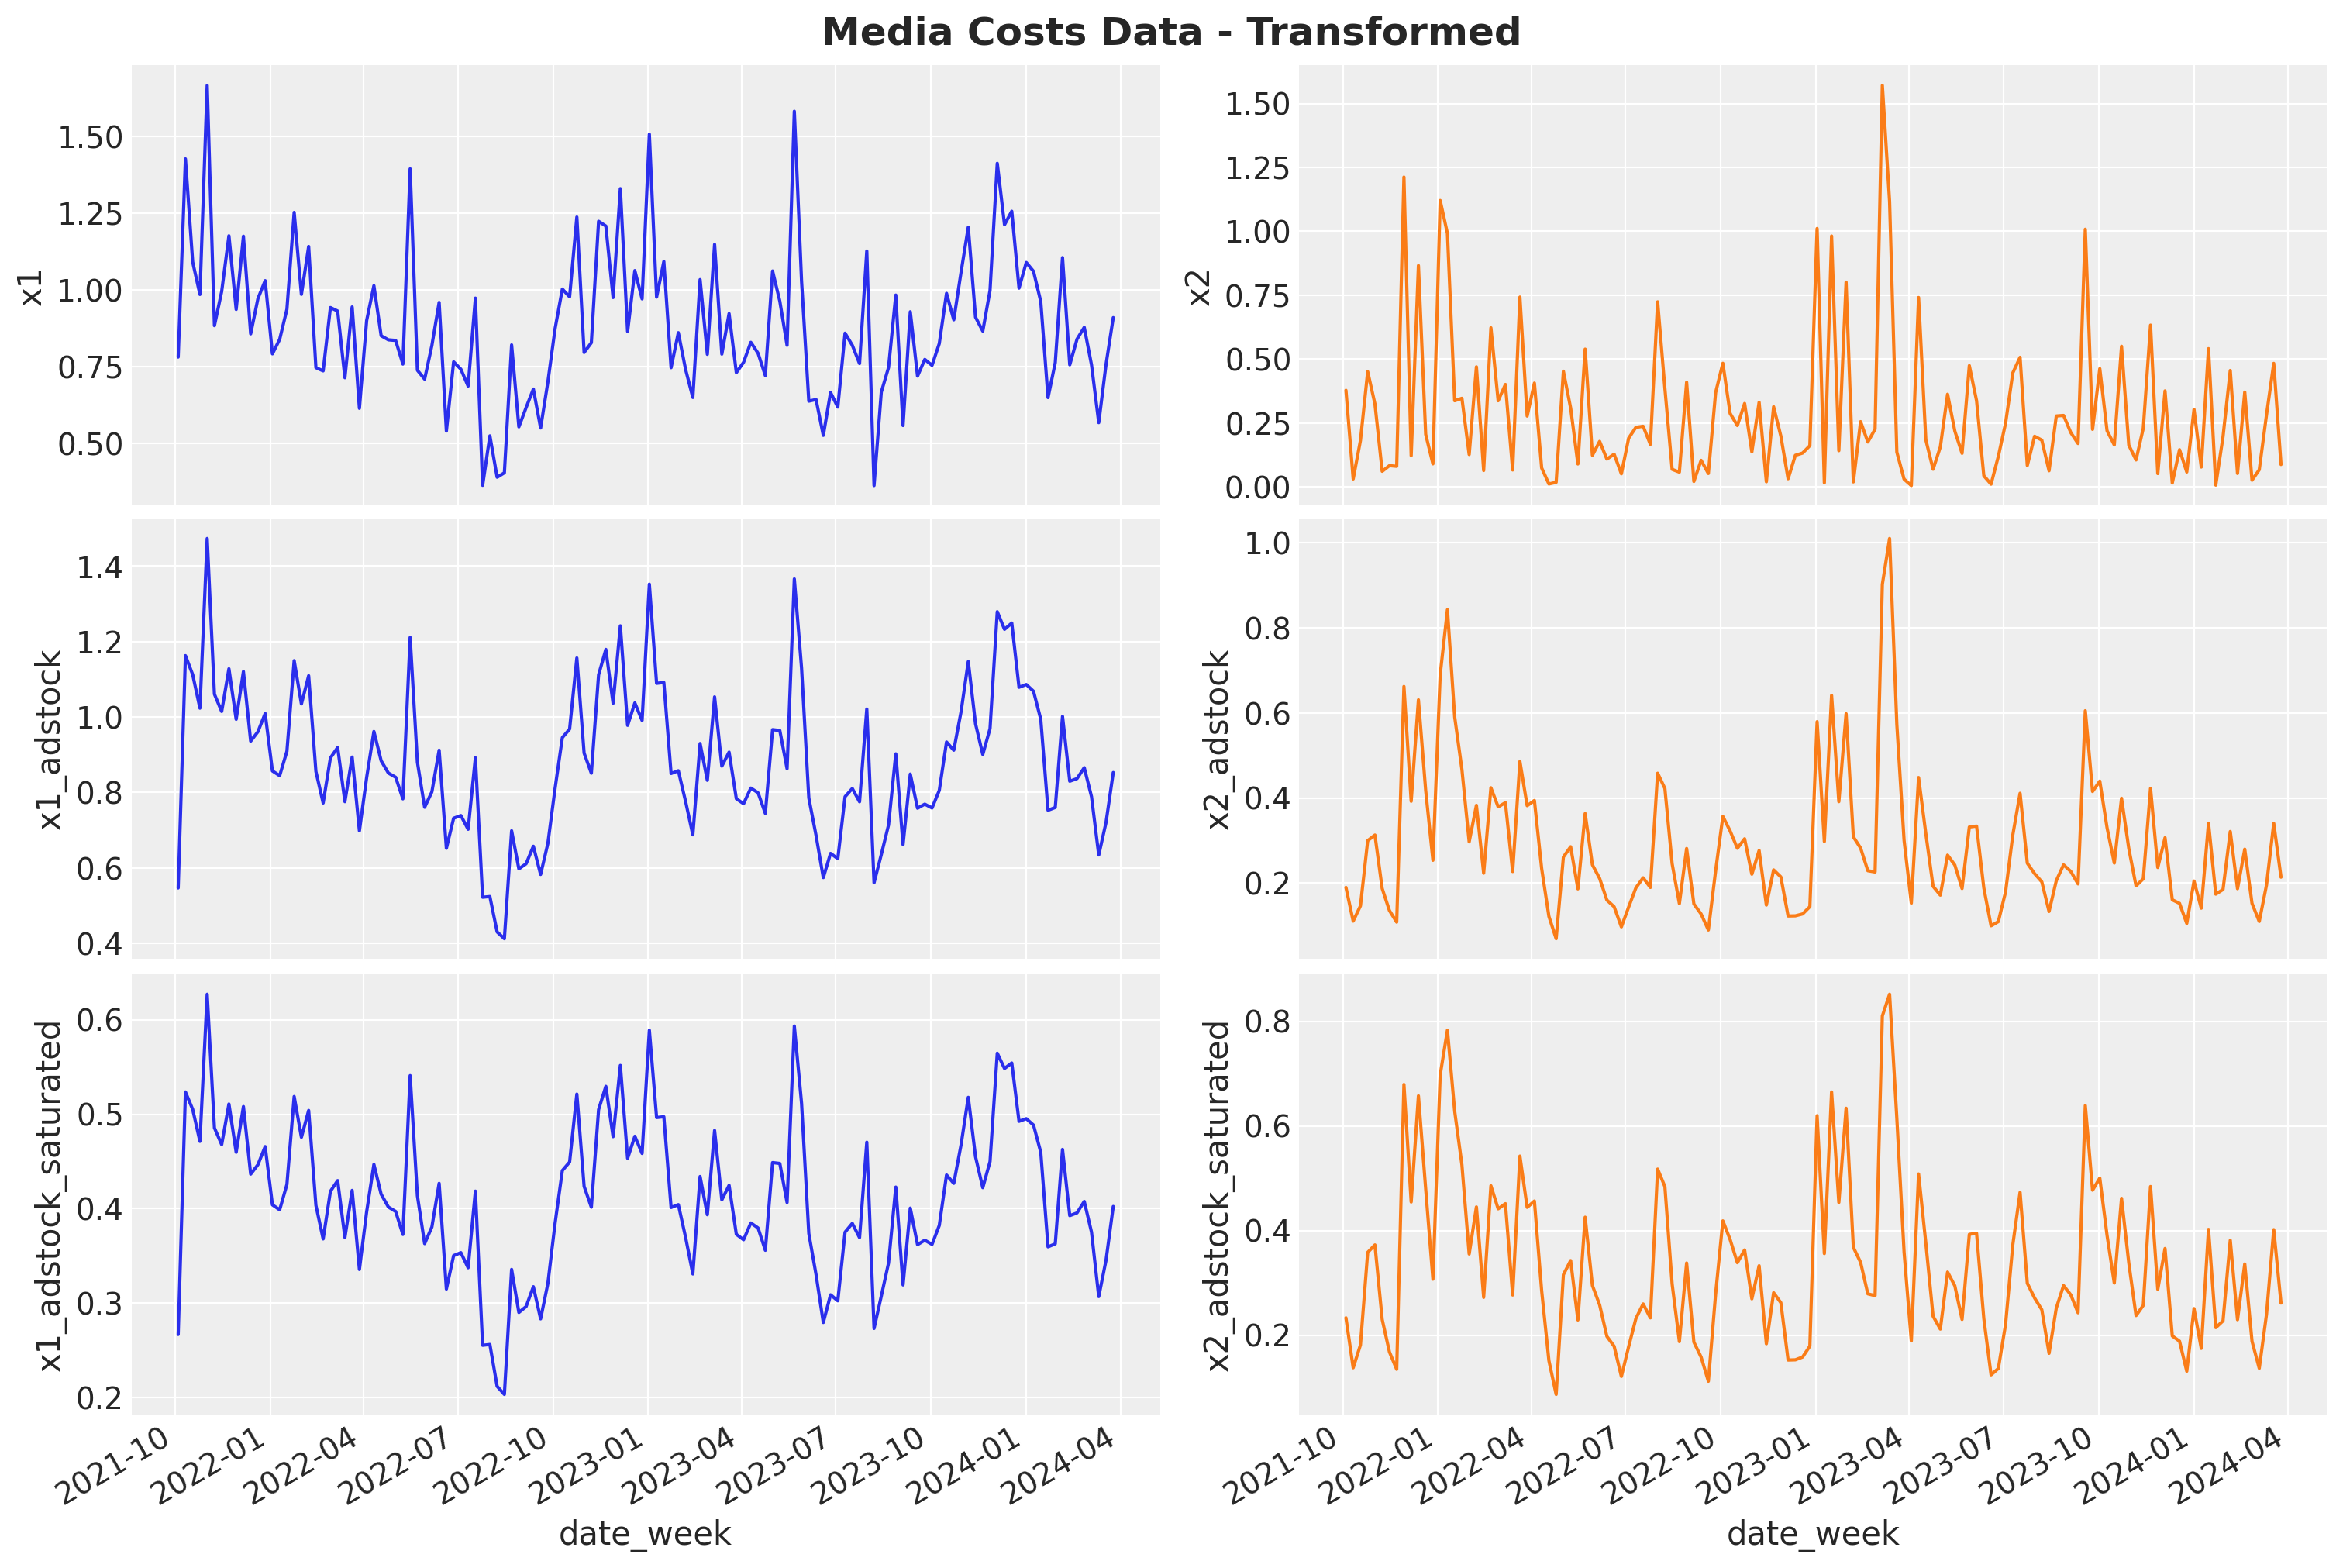

In [11]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(15, 10), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(
    x="date_week", y="x1_adstock_saturated", data=data_df, color="C0", ax=ax[2, 0]
)
sns.lineplot(
    x="date_week", y="x2_adstock_saturated", data=data_df, color="C1", ax=ax[2, 1]
)
fig.autofmt_xdate()
fig.suptitle("Media Costs Data - Transformed", fontsize=18, fontweight="bold")

In [12]:
beta1: float = 2.0
beta2: float = 1.5

data_df = data_df.eval(
    f"""
    x1_effect = {beta1} * x1_adstock_saturated
    x2_effect = {beta2} * x2_adstock_saturated
    y = trend + seasonality + z + x1_effect + x2_effect + epsilon
    """
)

Text(0.5, 0.98, 'Data Generating Process - Components')

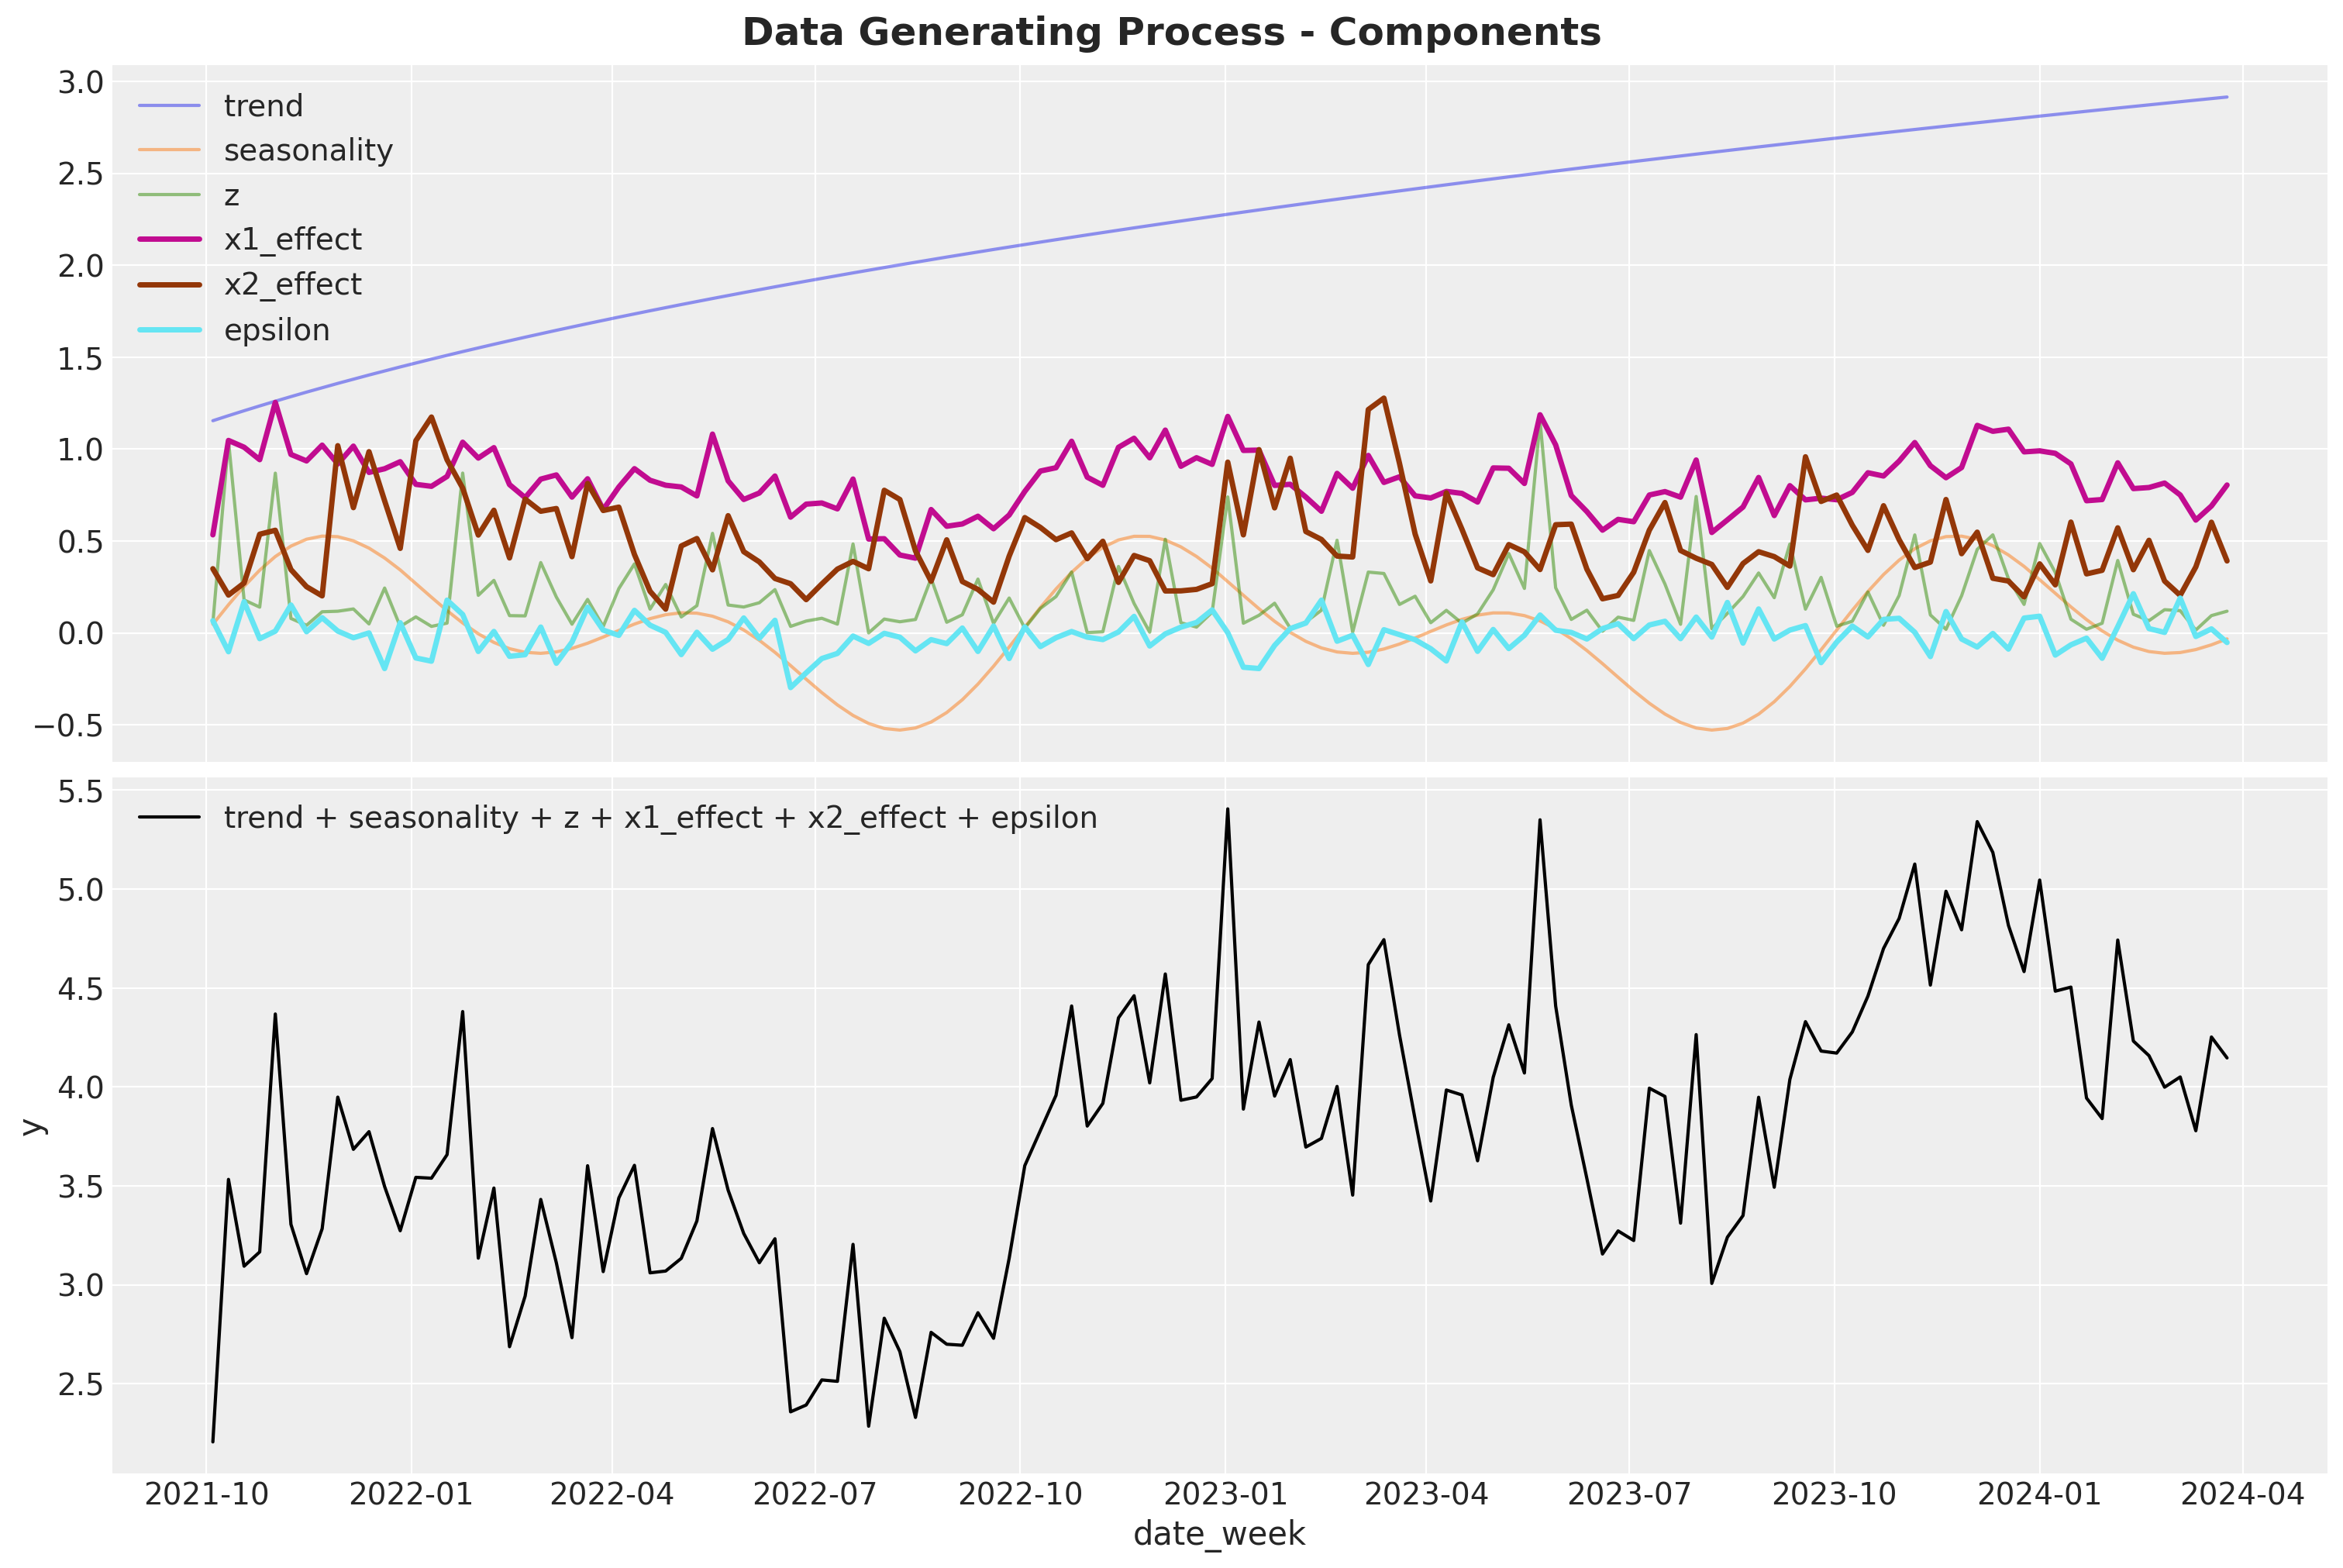

In [14]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(
    data=data_df, x="date_week", y="z", color="C2", alpha=0.5, label="z", ax=ax[0]
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="x1_effect",
    color="C3",
    linewidth=2.5,
    label="x1_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="x2_effect",
    color="C4",
    linewidth=2.5,
    label="x2_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date_week",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df,
    x="date_week",
    y="y",
    color="black",
    label="trend + seasonality + z + x1_effect + x2_effect + epsilon",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Generating Process - Components", fontsize=18, fontweight="bold")